In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from glob import glob #not used
from IPython.display import display #not used
import matplotlib.pyplot as plt
from math import pi #not used
import seaborn as sns #not used
from scipy import signal
import pywt



**Data cleaning and understanding**

Reading the EEG data from the provided four electrodes by running the file collected during the long blink session equally long (510 points pro session). Conduct the preliminary data processing and visualization steps to gain some insight from the EEG recording:
- Splits and clean the data
- Selects the first 510 points for visualization

1. Are the amplitude value measure as microvolt? This information was not given
2. Are the index time series? If yes issit in seconds or milliseconds? Sampling frequency is 215 Hz at 2 seconds
3. What does 510 points pro session mean? It is an arbitrary decision from the data manager
4. Do we need more information about the four electrodes? No further knowledge is required

**Step 1 Data cleaning and understanding**

1.1 Load data, and parsing it from string to appropriate data type
1.2 Select the first 510 points for visualization

Text(0.5, 1.0, 'The first 510 points of Long Blink')

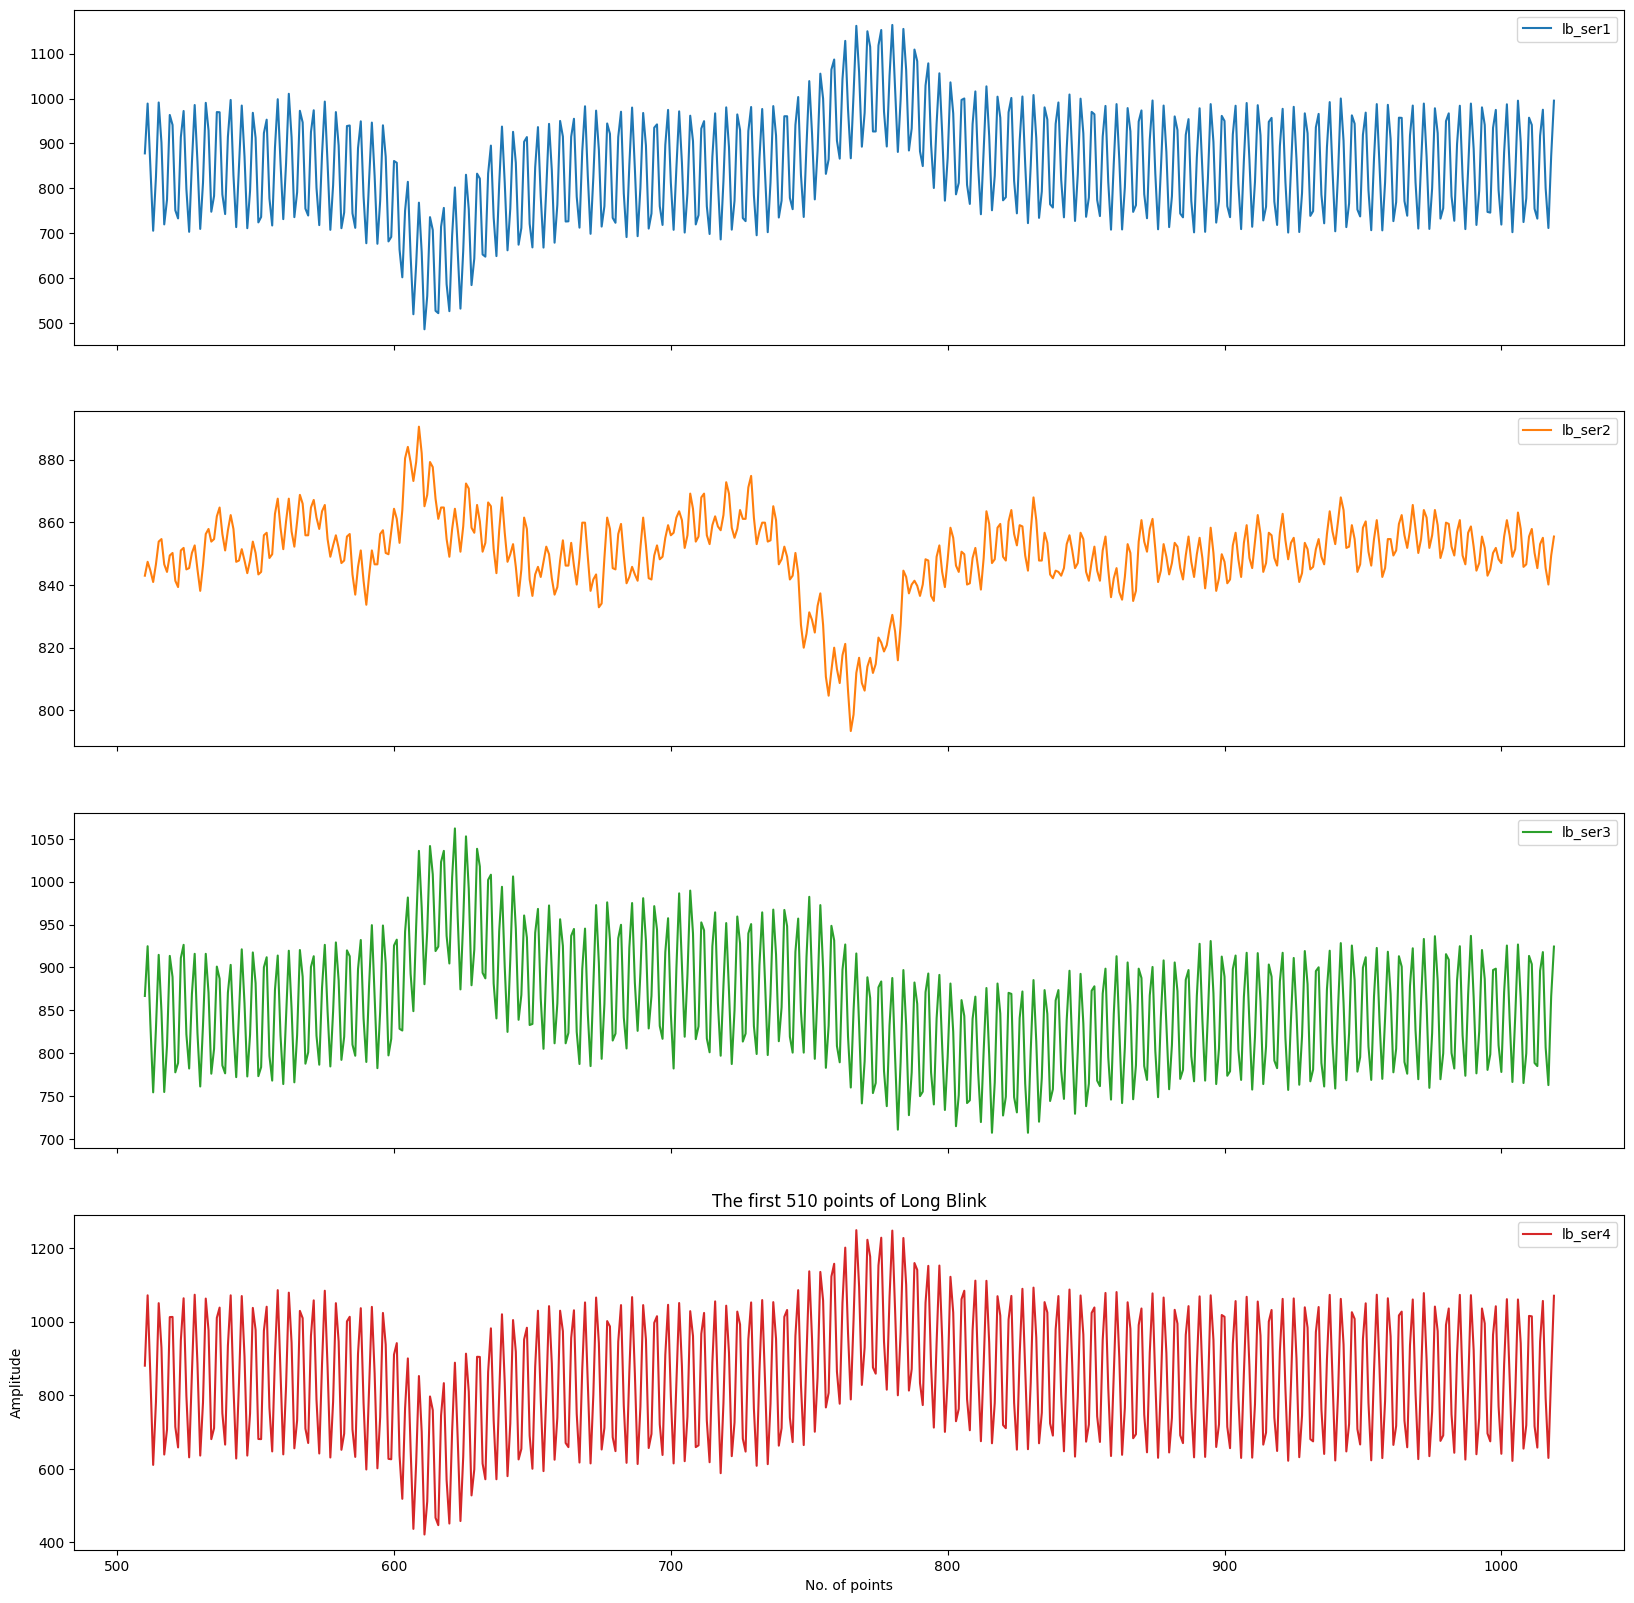

In [2]:
#Long blink data
df1 = pd.read_csv('data\\LongBlink.csv', sep = ",")
df1[['Col1', 'Col2', 'Col3', 'Col4']] = df1['data'].str.split(',', expand=True)
#Remove the original 'HeaderColumn' column
df1.drop(columns=['data'], inplace=True)
df1.head(5)
lb_ser1 = df1.iloc[:,0].str.strip('[').astype(float) #to remove square brackets and convert to float
lb_ser2 = df1.iloc[:,1].astype(float) #convert to float
lb_ser3 = df1.iloc[:,2].astype(float) #convert to float
lb_ser4 = df1.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
#ser 1,2,3,4 are numpy arrays, length: 25500, dtype: float64
df1 = pd.concat([lb_ser1, lb_ser2, lb_ser3, lb_ser4], axis=1) #concatenate the columns
df1.columns = ['lb_ser1', 'lb_ser2', 'lb_ser3', 'lb_ser4'] #rename the columns
#extract the first 510 points of the data as sample and visualize it
df1_sample = df1.iloc[510:1020] 
df1_sample.plot.line(subplots=True, figsize=(20, 20))
plt.xlabel('No. of points')
plt.ylabel('Amplitude')
plt.title('The first 510 points of Long Blink')

**Step 2: Data format compatibility** 

Generating a .fif file from csv to fit the raw data format used in MNE-python package for analysis

In [3]:
import mne
#source: https://colab.research.google.com/drive/1ro2XBhpUKIlV5JCytetKoNFrVOCgdLAP?usp=sharingLink#scrollTo=T4VzMOJKSXlz
#source: https://mne.tools/dev/auto_tutorials/preprocessing/10_preprocessing_overview.html

n_channels = len(df1.columns) 
ch_names = list(df1.columns) #list of channel names
print(ch_names)
values = df1.T*1e-7 #scale the signal value 
ch_types = ['eeg']*df1.shape[1]

sampling_freq = 215 

info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)
raw_lb = mne.io.RawArray(values, info)

raw_lb.save('.\\data\\raw_lb.fif', overwrite=True)

['lb_ser1', 'lb_ser2', 'lb_ser3', 'lb_ser4']
Creating RawArray with float64 data, n_channels=4, n_times=25500
    Range : 0 ... 25499 =      0.000 ...   118.600 secs
Ready.


C:\Users\charl\AppData\Local\Temp\ipykernel_25376\4137458740.py:16: RuntimeWarning: This filename (d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_lb.save('.\\data\\raw_lb.fif', overwrite=True)


Overwriting existing file.
Writing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif
Closing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif
[done]


**Artifact detection**

MNE-Python includes a few tools for automated detection of certain artifacts (heartbeats and blinks), but one can always visually inspect the data to identify and annotate artifacts as well. Before we look at artifacts we set aside SSP projectors in a separate variable and then remove them from Raw object using del_proj() method so that we can inspect our data in its original, raw state. # Signal-space projection (SSP) is a technique for removing noise from EEG and MEG signals by projecting the signal onto a lower-dimensional subspace

In [4]:
ssp_projectors = raw_lb.info['projs']
raw_lb.del_proj()

<RawArray | 4 x 25500 (118.6 s), ~806 kB, data loaded>

**Low-frequency drifts**

Low-frequency drifts are most readlily detected by visual inspection using the basic plot() method, it is helpful to plot a relatively long time spac and to disable channel-wise DC shift correction. Here, 60 seconds is plotted to show all the magnetometer channels.

Using matplotlib as 2D backend.


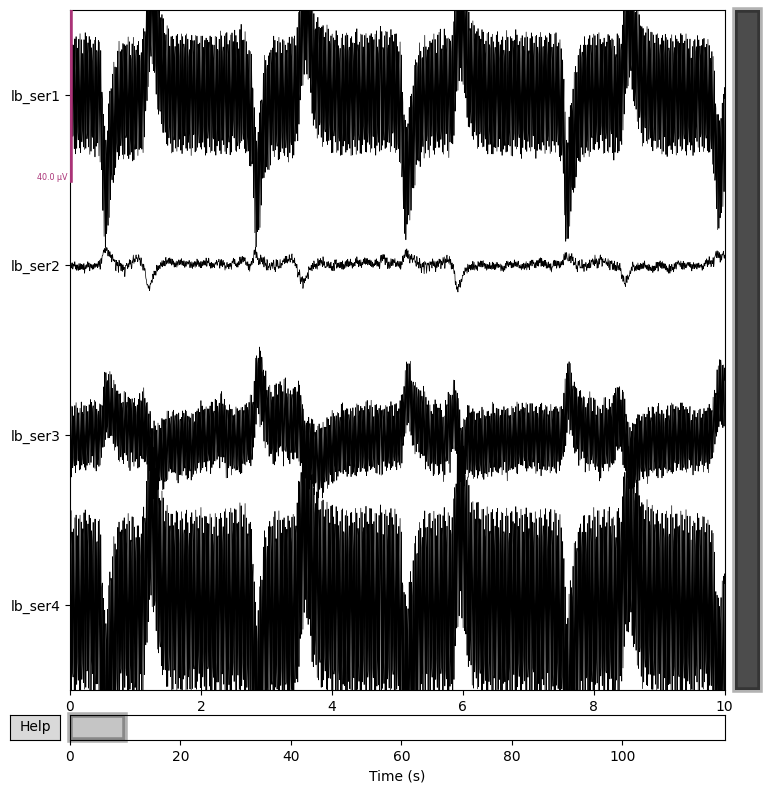

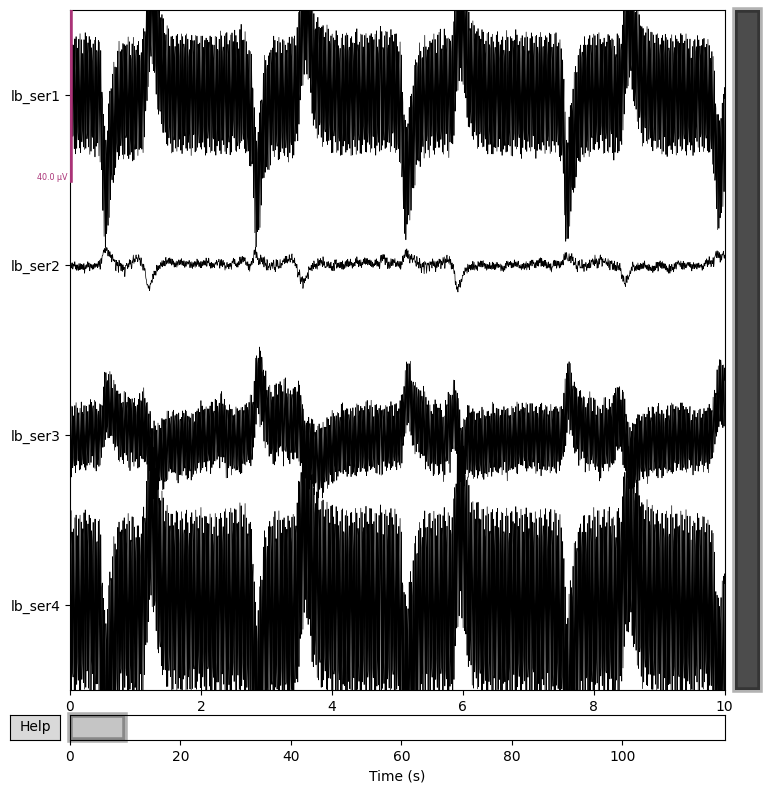

In [5]:
# raw.plot(duration=60, order=eeg_channel, n_channels=len(eeg_channel), remove_dc=False)
raw_lb.plot(duration=2, order=eeg_channel, remove_dc=True)
# raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 9.526 (s)


d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\.venv\lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


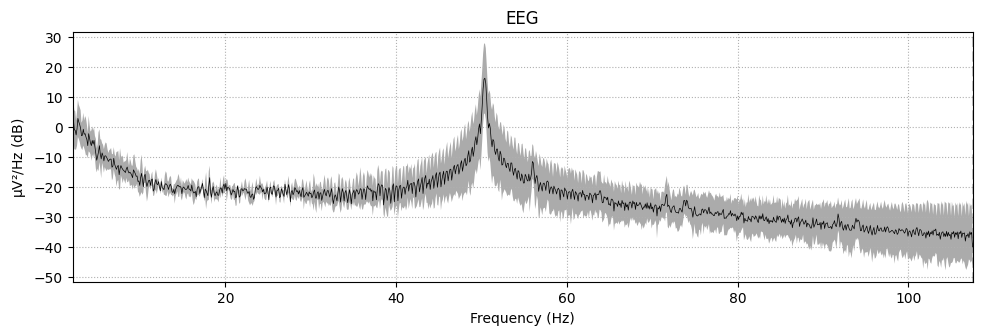

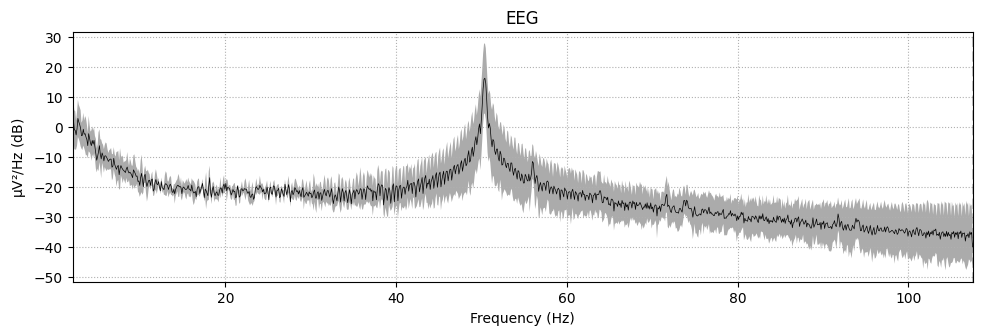

In [6]:
#PSD (power spectral density) provides information about the distribution of power across different frequencies in the EEG signal.
raw_lb.plot_psd(tmin=0, tmax=50, fmin=2, fmax=107.5, average=True) #

In [ ]:
raw_lb.compute_psd().plot(average=True, picks="data", exclude="bads").show()

In [7]:
# get pandas dataframe from raw format
data_lb = raw_lb.to_data_frame()
data_lb = data_lb.drop("time", axis=1) #drop "time" column
#get pandas series to use in data preprocessing
lb_ser1 = data_lb["lb_ser1"]
lb_ser3 = data_lb["lb_ser3"]
lb_ser4 = data_lb["lb_ser4"]
lb_ser2 = data_lb["lb_ser2"]

print(type(lb_ser1))
data_lb

<class 'pandas.core.series.Series'>


,lb_ser1,lb_ser2,lb_ser3,lb_ser4
0,83.003663,84.978022,82.278388,82.761905
1,71.963370,84.091575,76.315018,63.179487
2,84.655678,84.655678,85.179487,83.043956
3,98.798535,85.340659,92.351648,106.776557
4,87.959707,84.816850,85.219780,91.223443
...,...,...,...,...
25495,80.868132,84.010989,83.648352,80.223443
25496,72.809524,84.172161,80.666667,67.289377
25497,85.904762,84.937729,86.670330,85.703297
25498,96.945055,85.260073,90.901099,102.908425


In [ ]:
# getting de pandas dataframe from the raw format
data_lb1 = raw_lb.to_data_frame()
data_lb1 = data_lb1.drop("time", axis=1) # drop the column time
data_lb1

**Data Preprocessing**

2.1 Filtering 

source : (https://neuraldatascience.io/7-eeg/erp_filtering.html)
Filtering typically occurs at two points in the EEG pipeline:  at the time the data is recorded and during preprocessing. The filters used during preprocessing are third-order:
* median filter
* low pass filter
* high pass filter
* notch filter

Firstly, the raw data were filtered using the third-order median filter for denoising and smoothing the signal  by replacing each data point with the median value. Subsequently, the fifth-order Butterworth filter was used for low-pass and high-pass filtering to remove unwanted frequencies from the signal.

I learned that it is important to consider Nyquist theorem, where the highest measurable frequency is half the sampling rate. Signal frequencies higher than Nyquist frequency *alias*, thus it is necessary to filter out the components that are higher than Nyuquist frequency (source: https://link.springer.com/content/pdf/10.3758/BF03209412.pdf).  
I will be working with signal that's sampled at 215 Hz at 2 seconds long, starting with long blink data, followed by the short blink data. 



In [ ]:
# Define the slice to display in the following code. Just change the value of 'SLICE_FROM' with 0 or a multiple of 510.
SLICE_FROM = 510
SLICE_TO = SLICE_FROM + 510

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5) -> tuple:
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data: pd.Series, lowcut: float, highcut: float, fs: float, order=5) -> np.ndarray:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


In [ ]:
#apply the median filter function
def median(data: pd.Series | np.ndarray) -> np.ndarray:# input: numpy array 1D (one column)
    #applying the median filter
    med_filtered= signal.medfilt(data, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return med_filtered # return the med-filtered signal: numpy array 1D

In [ ]:
#apply notch filter at 50hz
def notch_filter(time, band, freq, ripple, order, filter_type, data) -> np.ndarray:

    fs   = 1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = signal.iirfilter(
            order, 
            [low, high], 
            rp=ripple, 
            btype='bandstop',
            analog=False, 
            ftype=filter_type
        )
    
    a = signal.lfilter(b, a, data)
    return a

In [ ]:
def preprocessing(data: pd.DataFrame, slice_from: int, slice_to: int) -> pd.DataFrame:
    # butter bandpass filter parameters
    lowcut = 0.5
    highcut = 40
    fs = 215
    order = 4
    
    # notch filter parameters
    time = 1/215
    band = 4
    freq = 50
    ripple = 1
    order = 2
    filter_type = 'butter'

    # create an empty pandas DataFrame
    cleaned_data = pd.DataFrame()

    # loop through all columns and apply filters
    for key, value in data.items():

        # for each column plot all the filters results
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10,15))

        # apply butter bandpass filter
        series_bbf = butter_bandpass_filter(value, lowcut, highcut, fs, order)

        # apply median filter
        series_mf = median(series_bbf)

        # apply notch filter
        series_nf = notch_filter(time, band, freq, ripple, order, filter_type, series_mf)

        # add the processed data to the dataframe
        cleaned_data[key] = series_nf

        # plot each steps ax0 raw value, ax1 after butter bandpass, ax2 after median, ax3 after notch filter.
        ax0.plot(value[slice_from:slice_to])
        ax0.set_title('Raw data')

        ax1.plot(series_bbf[slice_from:slice_to], color="red")
        ax1.set_title('After butter bandpass filter')

        ax2.plot(series_mf[slice_from:slice_to], color="orange")
        ax2.set_title('+ median filter')

        ax3.plot(series_nf[slice_from:slice_to], color="green")
        ax3.set_title('+ notch filter')
        
        fig.suptitle(f"Filters apply to '{key}'")

    return cleaned_data

In [ ]:
lb_cleaned = preprocessing(data_lb1, SLICE_FROM, SLICE_TO)

In [ ]:
#code source: https://www.daanmichiels.com/blog/2017/10/filtering-eeg-signals-using-scipy/
#apply signal.firwin function : FIR (finite impulse response) filter to process the signal
#choose the cutoff frequency
cutoff_freq = [0.01, 0.06] #Hz
filter = sp.signal.firwin(430, [0.01, 0.06], pass_zero=False)

plt.figure(figsize=(12, 6))
plt.plot(filter)
plt.title("Filtered EEG Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_compare(
        df_original: np.ndarray | pd.DataFrame, 
        df_cleaned: np.ndarray | pd.DataFrame,
        slice_from: int, 
        slice_to: int, 
        color_original: str="blue", 
        color_cleaned: str="orange",
        name: str=""
) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
    ax1.plot(df_original[slice_from:slice_to], color_original)
    ax2.plot(df_cleaned[slice_from:slice_to], color_cleaned)
    fig.suptitle(f"Before and after signal processing {name}")

In [ ]:
#FIR (finite impulse response) filter to process in series 1 and compare the results
lb1_clean = signal.convolve(lb_cleaned['lb_ser1'], filter, mode='same')
plot_compare(lb_cleaned['lb_ser1'], lb1_clean, SLICE_FROM, SLICE_TO, color_original="green", name="long blink ser1")

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 2 and compare the results
lb2_clean = signal.convolve(lb_cleaned['lb_ser2'], filter, mode='same')
plot_compare(lb_cleaned['lb_ser2'], lb2_clean, SLICE_FROM, SLICE_TO, color_original="green", color_cleaned="orange", name="long blink ser2")

In [ ]:
#FIR (finite impulse response) filter to process the first 510 points in series 3 and compare the results
lb3_clean = signal.convolve(lb_cleaned['lb_ser3'], filter, mode='same')
plot_compare(lb_cleaned['lb_ser3'], lb3_clean, SLICE_FROM, SLICE_TO, color_original="green", color_cleaned="red", name="long blink ser3")

In [ ]:
lb4_clean = signal.convolve(lb_cleaned['lb_ser4'], filter, mode='same')
plot_compare(lb_cleaned['lb_ser4'], lb4_clean, SLICE_FROM, SLICE_TO, color_original="green", color_cleaned="magenta", name="long blink ser4")

In [ ]:
#Fourier transform
from scipy import fftpack # import fftpack to use all fft functions
from numpy.fft import * # import fft to use fft functions
# Inputs: time signal 1D array
# Output: amplitude of fft components 1D array having the same lenght as the Input
def fast_fourier_transform_one_signal(t_signal):
    # apply fast fourrier transform to the t_signal
    complex_f_signal= fftpack.fft(t_signal)
    #compute the amplitude each complex number
    amplitude_f_signal=np.abs(complex_f_signal)
    # return the amplitude
    return amplitude_f_signal
##################### fast fourier transform for data frames #################
def fast_fourier_transform(t_window):
  f_window=pd.DataFrame() # create an empty dataframe will include frequency domain signals of window
  for column in t_window.columns: 
    t_signal=np.array(t_window[column]) # convert the column to a 1D numpy array
    f_signal= np.apply_along_axis(fast_fourier_transform_one_signal,0,t_signal) # apply the function defined above to the column
    f_window["freq_"+column[0:]]=f_signal # storing the frequency signal in f_window with an appropriate column name
  return f_window # return the frequency domain window

In [ ]:
#Short blink
df2 = pd.read_csv('data\\ShortBlink.csv', sep = ",")
df2[['Col1', 'Col2', 'Col3', 'Col4']] = df2['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df2.drop(columns=['data'], inplace=True)
df2.head(5)
sb_ser1 = df2.iloc[:,0].str.strip('[').astype(float) #remove square brackets and convert to float
sb_ser2 = df2.iloc[:,1].astype(float) #convert to float
sb_ser3 = df2.iloc[:,2].astype(float) #convert to float
sb_ser4 = df2.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
df2 = pd.concat([sb_ser1, sb_ser2, sb_ser3, sb_ser4], axis=1)
print(df2)
df2 = df2.iloc[0:510]
df2.plot.line(subplots=True, figsize=(20, 20))
df2

In [ ]:
# #band pass filter filter noise with amplification
# #band pass filter between 0.5 and 40 hz, source: https://www.kaggle.com/code/sam1o1/eeg-signal-processing
# Fs = 215;              # Sampling frequency, not used                    
# T = 1/Fs;              # Sampling period       
# L = 25500;             # Length of signal
# t = np.arange(0,L)*T;  # Time vector (use numpy.arange to an array of evenly spaced values between 0 and L-1, multiplied by T to get the time vector)

# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyq = 0.33 * fs #nyquist frequency at 1/3 of the sampling rate is the safest
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = signal.butter(order, [low, high], btype='band')
#     return b, a

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = sp.signal.lfilter(b, a, data)
#     return pd.Series(y) #return as pandas series

# lb_ser1_np = butter_bandpass_filter(lb_ser1, 0.5, 40, 215, 4)
# lb_ser2_np = butter_bandpass_filter(lb_ser2, 0.5, 40, 215, 4)
# lb_ser3_np = butter_bandpass_filter(lb_ser3, 0.5, 40, 215, 4)
# lb_ser4_np = butter_bandpass_filter(lb_ser4, 0.5, 40, 215, 4)

# data_lb = pd.concat([lb_ser1_np, lb_ser2_np, lb_ser3_np, lb_ser4_np], axis=1) #concatenate the columns
# data_lb[510:1020].plot(subplots=True, figsize=(20,20))
# plt.xlabel('No. of points')
# plt.ylabel('Amplitude')
# plt.title('The first 510 points of Long Blink')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

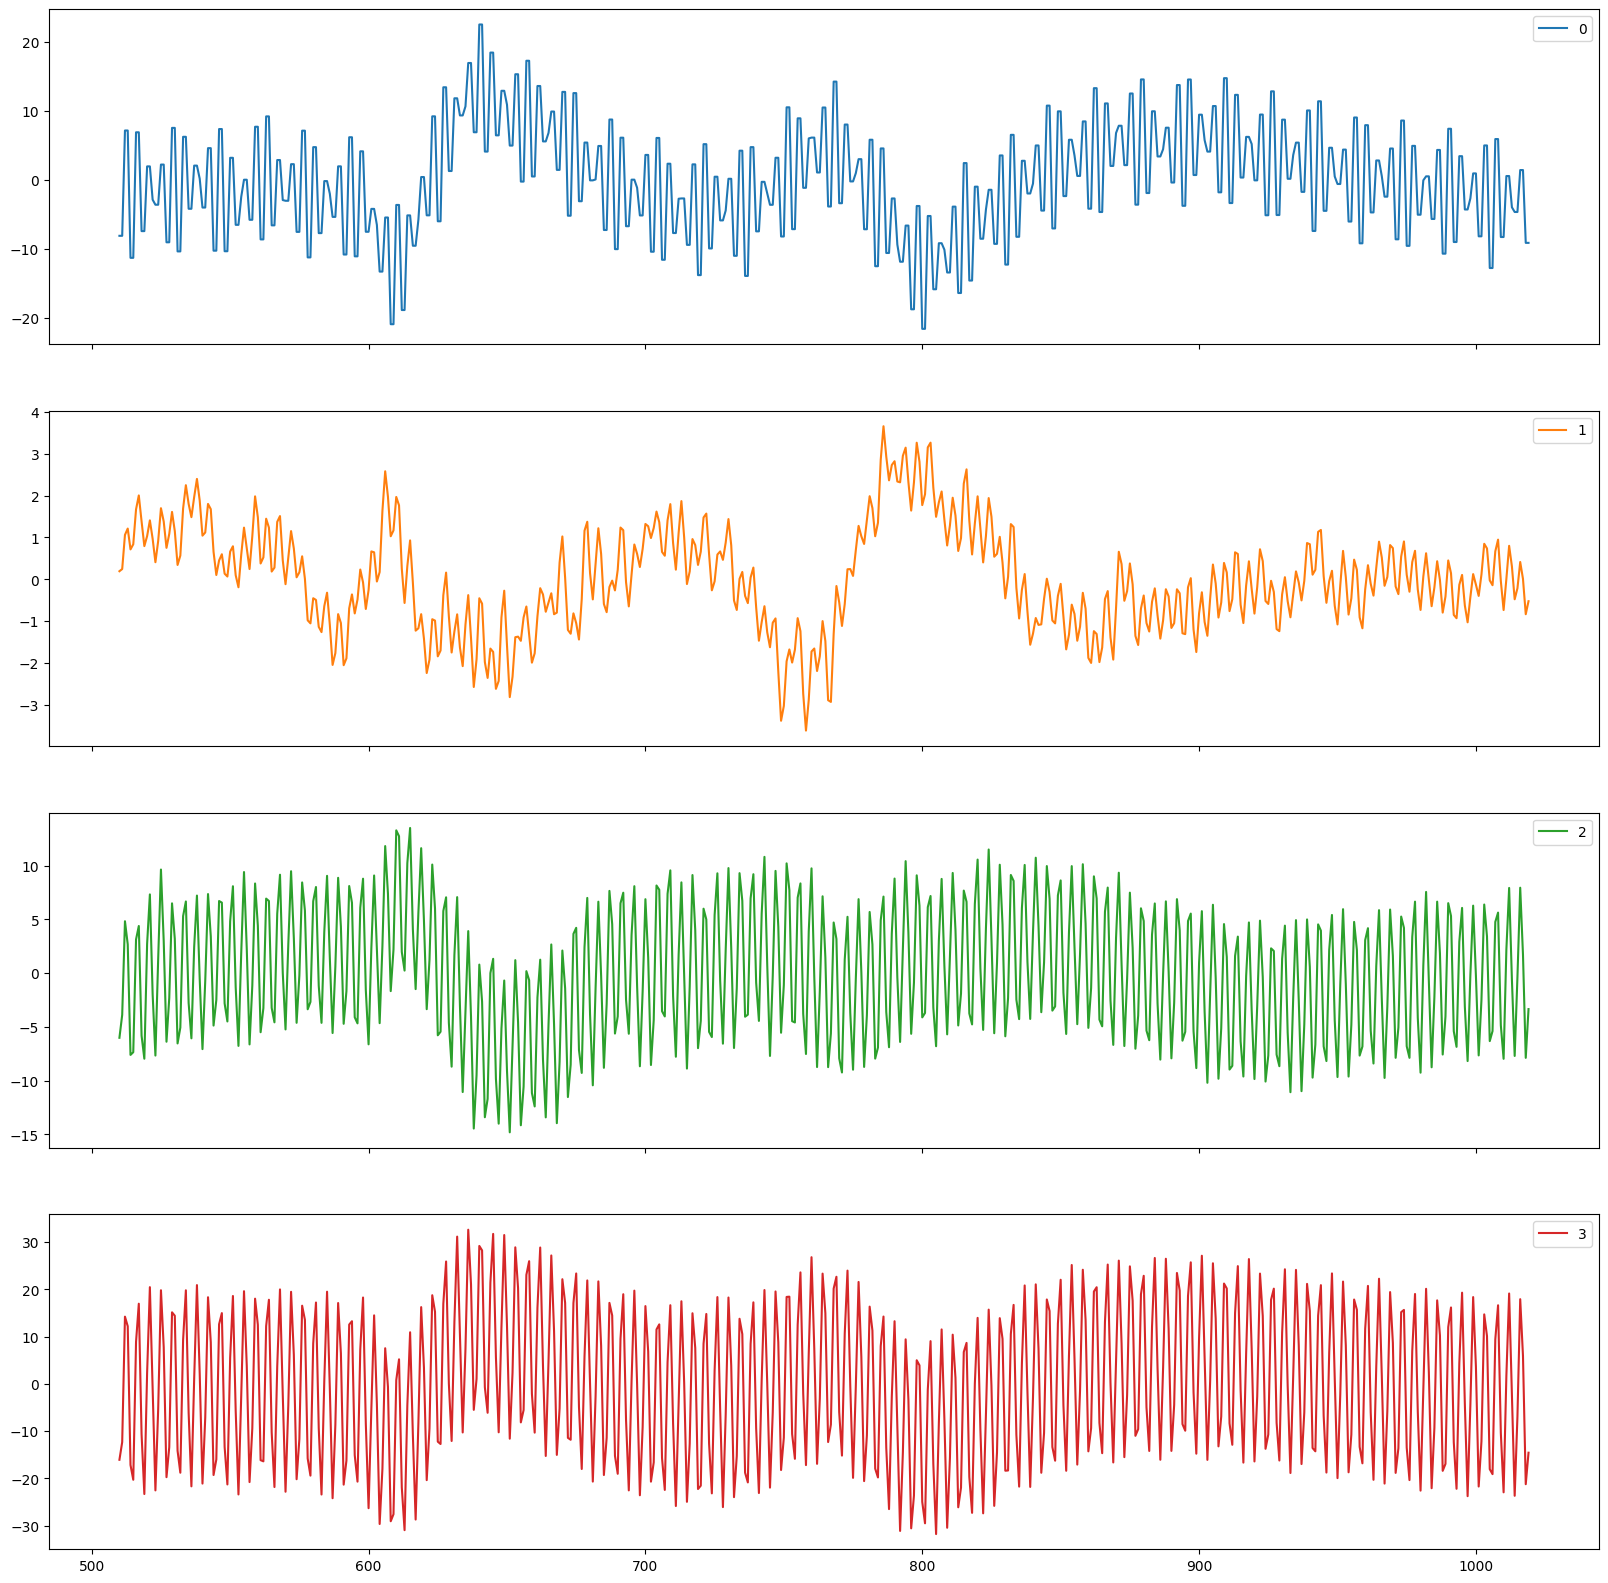

In [10]:
#apply the median filter function
def median(signal):# input: numpy array 1D (one column)
    array=np.array(signal)   
    #applying the median filter
    med_filtered=sp.signal.medfilt(array, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return  med_filtered # return the med-filtered signal: numpy array 1D

data_lb.iloc[:,0] = median(data_lb.iloc[:,0])
data_lb[510:1020].plot.line(subplots=True, figsize=(20, 20))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

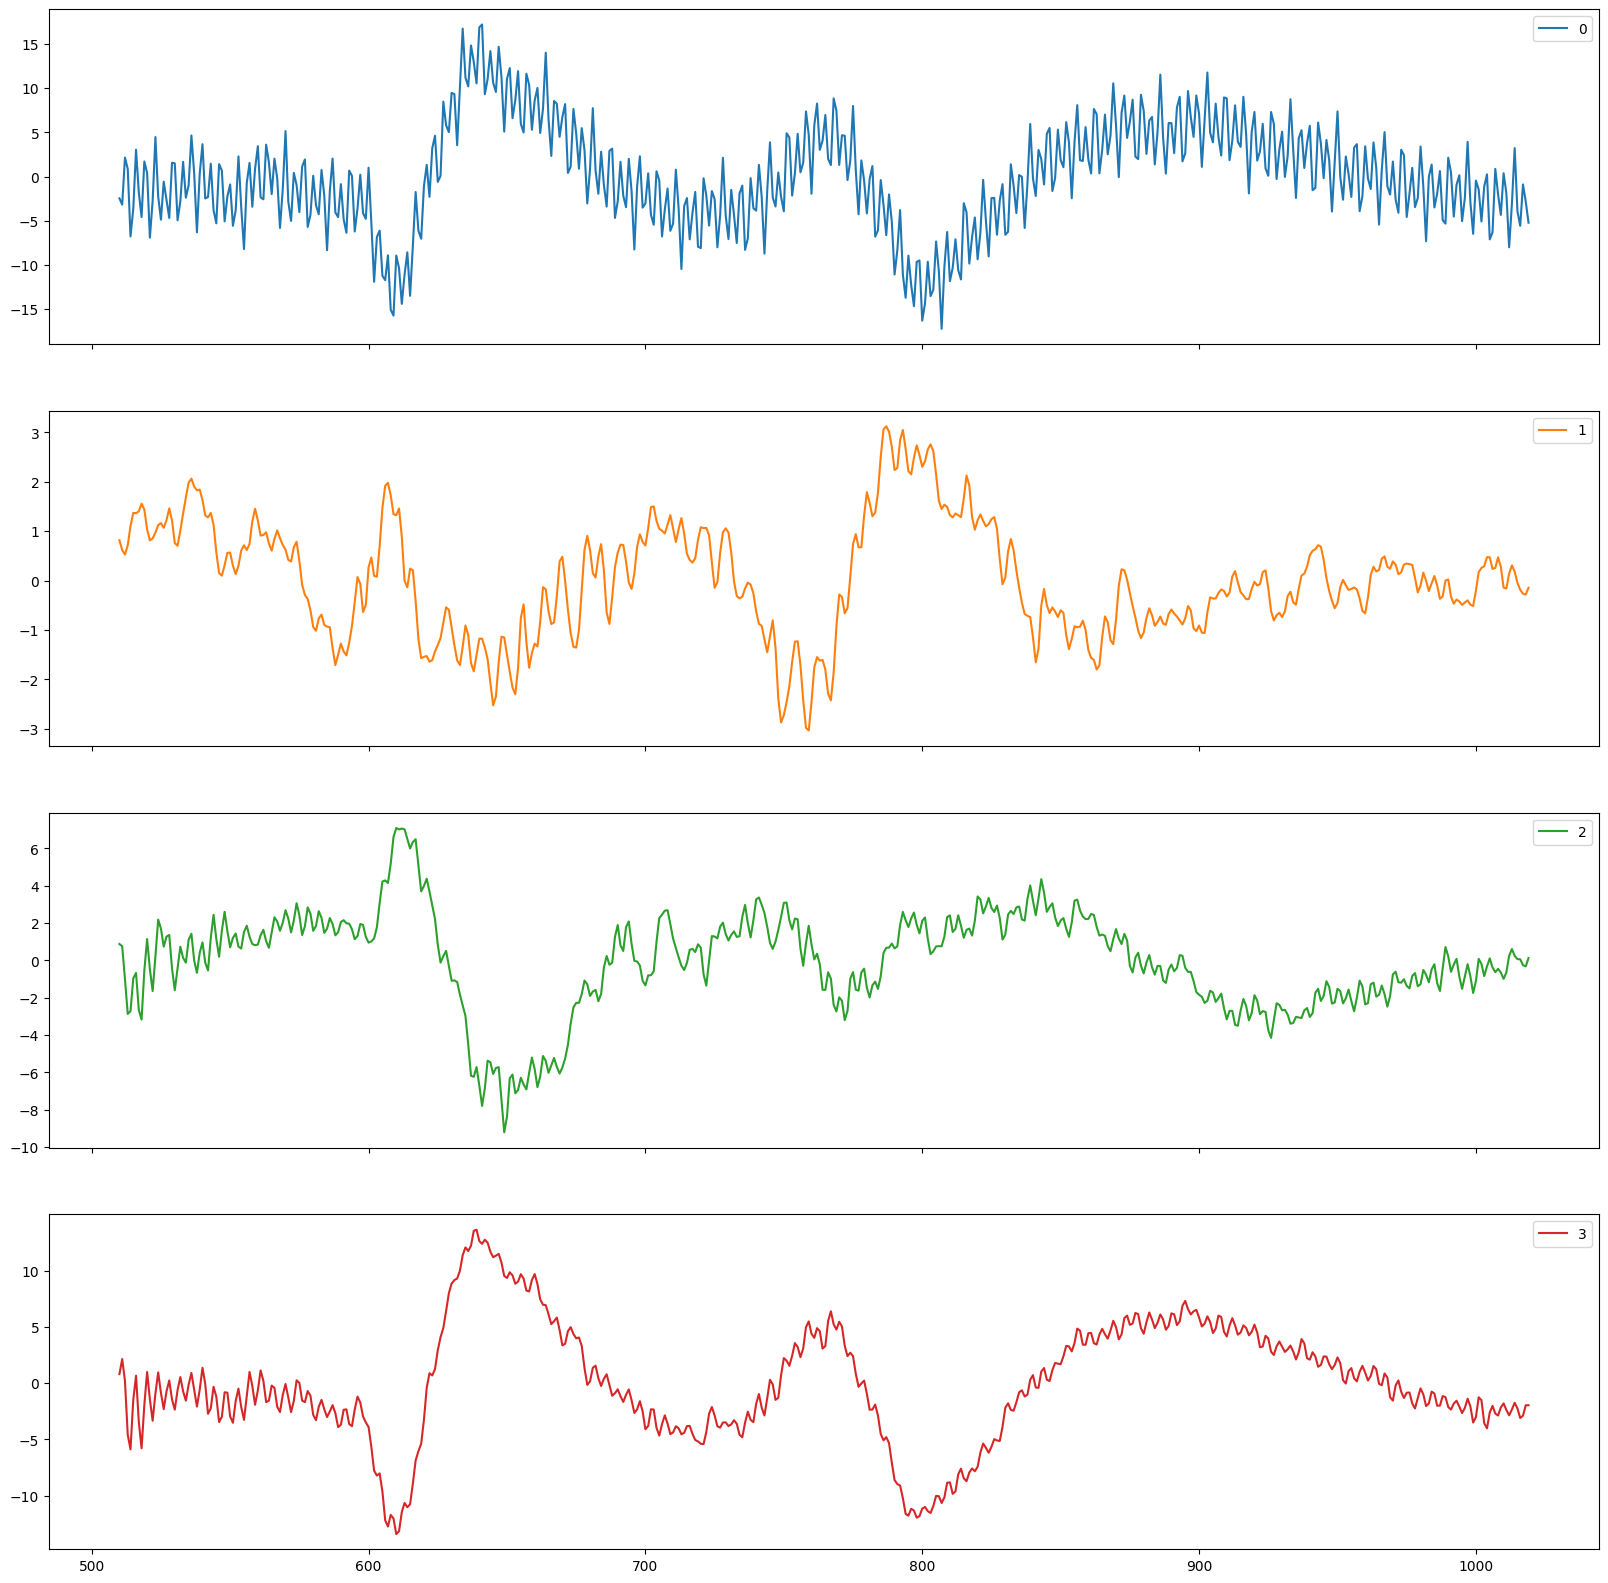

In [15]:
#apply notch filter at 50hz to remove power line noise (technical related artefact)
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data)-> pd.DataFrame:
    
    new_df = pd.DataFrame()

    for key, value in data.items(): #loop through every column in the dataframe, e.g. lb_ser1 as key

        fs   = 1/time 
        nyq  = fs/2.0
        low  = freq - band/2.0
        high = freq + band/2.0
        low  = low/nyq 
        high = high/nyq
        b, a = sp.signal.iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                        analog=False, ftype=filter_type)
        filtered_data = sp.signal.lfilter(b, a, value)
        new_df[key] = filtered_data
    return new_df

data_lb = Implement_Notch_Filter(1/215, 4, 50, 1, 2, 'butter', data_lb)
data_lb[510:1020].plot.line(subplots=True, figsize=(20, 20))


**Wavelet Decomposition**

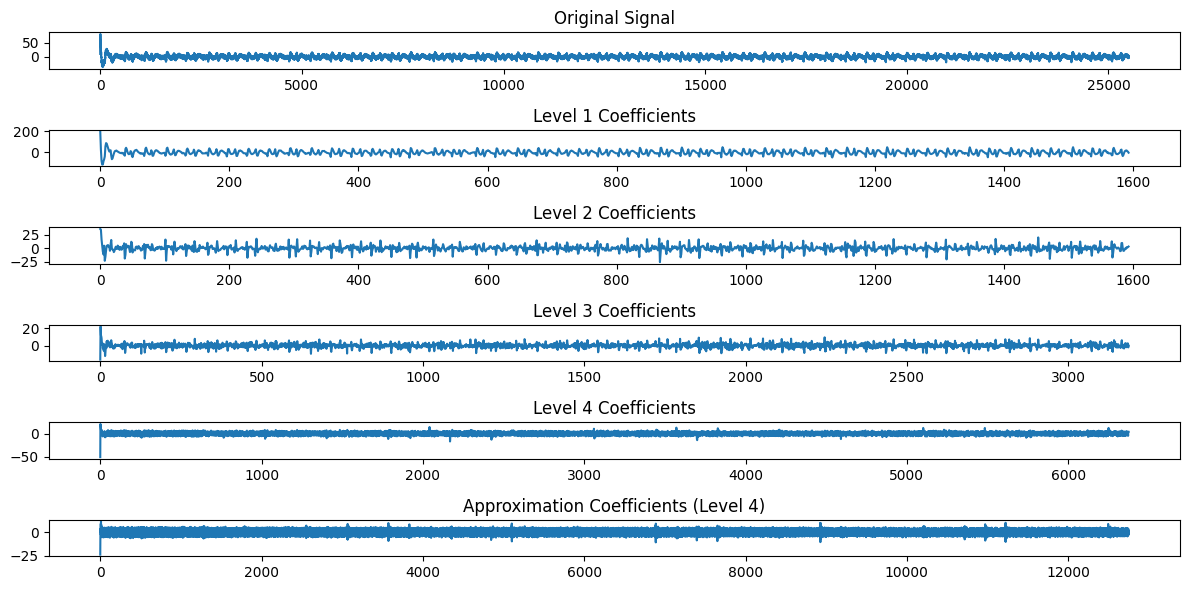

In [16]:
import pywt
# Wavelet decomposition
wavelet = 'db1'  # Choose a wavelet (Daubechies wavelet of order 1 in this case)
level = 4  # Number of decomposition levels
signal = data_lb.iloc[:,0]  # Signal to be decomposed

coeffs = pywt.wavedec(signal, wavelet, level=level)

# Plot the original signal and its wavelet coefficients
plt.figure(figsize=(12, 6))
plt.subplot(level + 2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')

for i in range(level):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(coeffs[i])
    plt.title(f'Level {i + 1} Coefficients')

plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[level])
plt.title(f'Approximation Coefficients (Level {level})')

plt.tight_layout()
plt.show()

In [ ]:
time_list=[]
for i in range (1,6):
    time=(time_sig_dic[Raw_data_paths[i][-15:-4]].index.values[-1])
    time_list.append(time)
data=np.array(time_list)
time_length=pd.DataFrame(data=data,columns=['Signl length'])
time_length

**Windowing**

(Rephrase) After filtering the signals, the clean signals were segmented using a sliding window. The process involved some steps. First, a 4-second width window was used to loop through the time-domain signal dividing it into small segments for 4 seconds each. The window width was decided based on the literature done. To decide whether the sliding window has to be overlapping or non-overlapping, both methods were tried. The result was that the overlapping method was more efficient and resulted in higher accuracy. We started with a 50% overlap.

Then, we tried different values until the highest accuracy was achieved at a 4-second sliding window and 3-second overlap. The segments after that were converted from the time-domain to the frequency-domain using the Fast Fourier transform. In addition to that, the signals were obtained in the time-frequency domain as stated in the features extracted in the time-frequency domain result in getting a higher classification accuracy. The Wavelet transformation was used in converting the signals to the time-frequency domain.

In [ ]:
def Windowing(time_sig_dic):
    
    
    """
    This Function is used to segment the data to small windows through 
    looping over each dataframe's index and store each 4 secs of the data 
    in a single window with a key that has this pattern
    the window size is calculated as follows:
    wind_size=(1/Fs)*required_window_time_length
    'Subject' + normalize2(int(subject_id))  +  '_' + str(state)
    INPUT ----> The denoised signal dictionary 
    OUTPUT ---> A dictionary that contains the windows 
    """
    window_dict={} 
    columns=time_sig_dic['Subject02_0'].columns
    
    for subject_id , state in zip([0,1,2,3,4],[0,1,0,1,0]):
        
        
    
        file_key= 'Subject' + normalize2(int(subject_id))  +  '_' + str(state)
        dic_update=raw_dic[file_key]
        for sig_time in range(0,len(time_length)):
            
            
            
            sig_time_length=(time_length['Signl length'][sig_time])
            window_ID=0
            for cursor in range(0,(sig_time_length-199),50):
                end_point=cursor+200
                data=np.array(dic_update.iloc[cursor:end_point])
                window=pd.DataFrame(data=data,columns=columns)
                key='t_W'+normalize5(window_ID)+'_'+file_key
                window_dict[key]=window
                wind_dic=window_dict[key]
                window_ID=window_ID+1
    return window_dict

In [ ]:
#Independent Component Analysis (ICA) for artifact removal
